In [11]:
# !pip install --upgrade numpy
# !pip install --upgrade mxnet==1.9.1  # Downgrade mxnet to a version that is compatible with your numpy version

import numpy as np
np.bool = np.bool_  # Add this line to resolve the issue
import os
import cv2
import pandas as pd
import pickle
import mxnet as mx
import pickle
from google.colab import drive
from google.colab.patches import cv2_imshow

In [12]:
drive.mount('/content/drive')
path = '/content/drive/MyDrive/biometric'
os.listdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['dataset', '2dface_preprocessing.ipynb']

In [13]:
#face detection model
faceDetectionModel = '/content/drive/MyDrive/test_cv/project_titv/models/res10_300x300_ssd_iter_140000_fp16.caffemodel'
#mô tả kiến trúc
faceDetectionProto = '/content/drive/MyDrive/test_cv/project_titv/models/deploy.prototxt.txt'
#mô tả khuôn mặt
faceDescriptor = '/content/drive/MyDrive/test_cv/project_titv/models/openface.nn4.small2.v1.t7'
#sử dụng opencv dnn đọc mô hình nhận diện khuôn mặt
detectorModel = cv2.dnn.readNetFromCaffe(faceDetectionProto, faceDetectionModel)

#đọc mô hình mô tả khuôn mặt từ file Torch
descriptorModel= cv2.dnn.readNetFromTorch(faceDescriptor)

In [14]:
# Khởi tạo biến đếm toàn cục
global_face_index = 0

def myDetect(image_input, target_size=(170, 200)):

    # Kiểm tra loại đầu vào
    if isinstance(image_input, str):  # Nếu là đường dẫn
        img1 = cv2.imread(image_input)
        if img1 is None:
            raise ValueError(f"Không thể đọc ảnh từ đường dẫn: {image_input}")
    elif isinstance(image_input, np.ndarray):  # Nếu là NumPy array
        img1 = image_input.copy()
    else:
        raise TypeError("Dữ liệu đầu vào phải là đường dẫn hoặc NumPy array.")

    global global_face_index  # Sử dụng biến toàn cục để theo dõi index khuôn mặt
    # Sao chép ảnh
    image = image_input.copy()
    # Lấy chiều cao và chiều rộng
    h, w = image.shape[:2]

    # Chuẩn bị dữ liệu đầu vào cho mô hình nhận diện khuôn mặt
    imgBlob = cv2.dnn.blobFromImage(image, 1.0, (300, 300), [104, 117, 123], swapRB=False, crop=False)

    # Thiết lập đầu vào cho mô hình
    detectorModel.setInput(imgBlob)

    # Thực hiện việc nhận diện khuôn mặt
    detections = detectorModel.forward()

    face_vectors = []  # Danh sách lưu trữ các vector đặc trưng
    face_count = 0  # Đếm số khuôn mặt được xử lý

    # Lặp qua tất cả các detections
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        # Chỉ xử lý khuôn mặt có độ tin cậy lớn hơn 0.5
        if confidence > 0.5:
            # Tính toán hộp bao quanh khuôn mặt
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype('int')

            # Kiểm tra kích thước hợp lệ của hộp
            if startX < 0 or startY < 0 or endX > w or endY > h:
                continue

            # Trích xuất vùng ảnh chứa khuôn mặt ra
            roi = image[startY:endY, startX:endX]
            # Resize khuôn mặt về kích thước chuẩn
            resized_roi = cv2.resize(roi, target_size)

            # Chuẩn bị dữ liệu đầu vào cho mô hình trích xuất đặc trưng
            faceBlob = cv2.dnn.blobFromImage(roi, 1/255, (96, 96), (0, 0, 0), swapRB=True, crop=True)

            # Thiết lập đầu vào cho mô hình trích xuất đặc trưng
            descriptorModel.setInput(faceBlob)

            # Thực hiện việc trích xuất đặc trưng
            vectors = descriptorModel.forward()

            # Lưu vector đặc trưng
            face_vectors.append(vectors)

             # In ra thông tin kèm theo index khuôn mặt
            global_face_index += 1  # Tăng index khuôn mặt
            print(f"Khuôn mặt {global_face_index}, độ tin cậy: {confidence}")
            cv2_imshow(resized_roi)
            face_count += 1  # Tăng đếm khuôn mặt

    print(f"Đã xử lý {face_count} khuôn mặt.")
    return face_vectors


Khuôn mặt 1, độ tin cậy: 0.9998014569282532


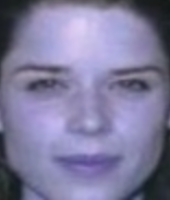

Đã xử lý 1 khuôn mặt.
Trích xuất đặc trưng thành công: Nhãn = 9
Khuôn mặt 2, độ tin cậy: 0.9988576173782349


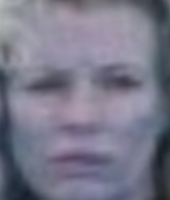

Đã xử lý 1 khuôn mặt.
Trích xuất đặc trưng thành công: Nhãn = 6
Khuôn mặt 3, độ tin cậy: 0.9993603825569153


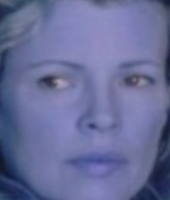

Đã xử lý 1 khuôn mặt.
Trích xuất đặc trưng thành công: Nhãn = 6
Khuôn mặt 4, độ tin cậy: 0.985056459903717


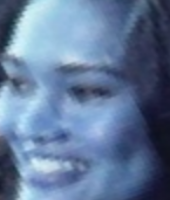

Đã xử lý 1 khuôn mặt.
Trích xuất đặc trưng thành công: Nhãn = 10
Khuôn mặt 5, độ tin cậy: 0.9991363883018494


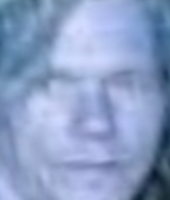

Đã xử lý 1 khuôn mặt.
Trích xuất đặc trưng thành công: Nhãn = 3
Khuôn mặt 6, độ tin cậy: 0.9818680286407471


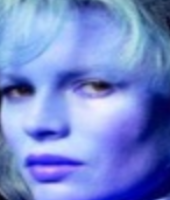

Đã xử lý 1 khuôn mặt.
Trích xuất đặc trưng thành công: Nhãn = 6
Khuôn mặt 7, độ tin cậy: 0.9991368651390076


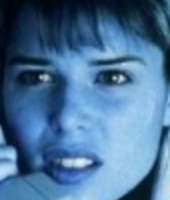

Đã xử lý 1 khuôn mặt.
Trích xuất đặc trưng thành công: Nhãn = 9
Khuôn mặt 8, độ tin cậy: 0.9994757771492004


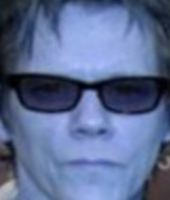

Đã xử lý 1 khuôn mặt.
Trích xuất đặc trưng thành công: Nhãn = 3
Khuôn mặt 9, độ tin cậy: 0.9986414313316345


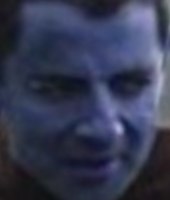

Đã xử lý 1 khuôn mặt.
Trích xuất đặc trưng thành công: Nhãn = 2
Khuôn mặt 10, độ tin cậy: 0.9985912442207336


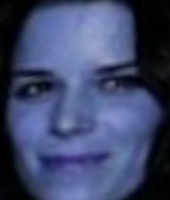

Đã xử lý 1 khuôn mặt.
Trích xuất đặc trưng thành công: Nhãn = 9
Khuôn mặt 11, độ tin cậy: 0.9993243217468262


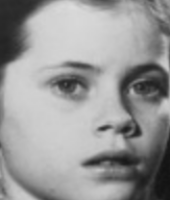

Đã xử lý 1 khuôn mặt.
Trích xuất đặc trưng thành công: Nhãn = 4
Khuôn mặt 12, độ tin cậy: 0.9995481371879578


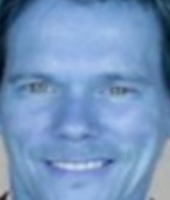

Đã xử lý 1 khuôn mặt.
Trích xuất đặc trưng thành công: Nhãn = 3
Khuôn mặt 13, độ tin cậy: 0.9991748929023743


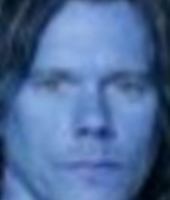

Đã xử lý 1 khuôn mặt.
Trích xuất đặc trưng thành công: Nhãn = 3
Khuôn mặt 14, độ tin cậy: 0.9981004595756531


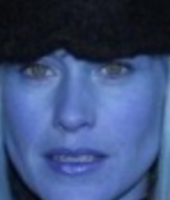

Đã xử lý 1 khuôn mặt.
Trích xuất đặc trưng thành công: Nhãn = 1
Khuôn mặt 15, độ tin cậy: 0.9995667338371277


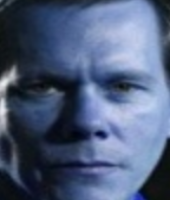

Đã xử lý 1 khuôn mặt.
Trích xuất đặc trưng thành công: Nhãn = 3
Khuôn mặt 16, độ tin cậy: 0.999645471572876


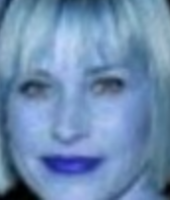

Đã xử lý 1 khuôn mặt.
Trích xuất đặc trưng thành công: Nhãn = 1
Khuôn mặt 17, độ tin cậy: 0.999536395072937


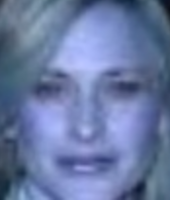

Đã xử lý 1 khuôn mặt.
Trích xuất đặc trưng thành công: Nhãn = 1
Khuôn mặt 18, độ tin cậy: 0.9932746887207031


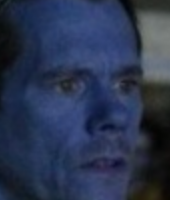

Đã xử lý 1 khuôn mặt.
Trích xuất đặc trưng thành công: Nhãn = 3
Khuôn mặt 19, độ tin cậy: 0.9995655417442322


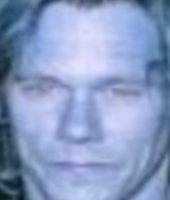

Đã xử lý 1 khuôn mặt.
Trích xuất đặc trưng thành công: Nhãn = 3
Khuôn mặt 20, độ tin cậy: 0.9998539686203003


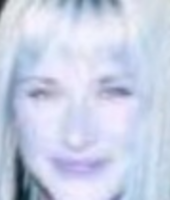

Đã xử lý 1 khuôn mặt.
Trích xuất đặc trưng thành công: Nhãn = 1
Khuôn mặt 21, độ tin cậy: 0.9975323677062988


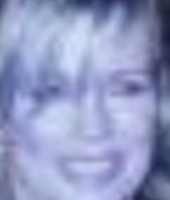

Đã xử lý 1 khuôn mặt.
Trích xuất đặc trưng thành công: Nhãn = 6
Khuôn mặt 22, độ tin cậy: 0.9984592199325562


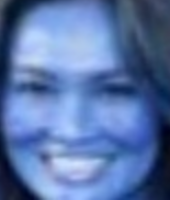

Đã xử lý 1 khuôn mặt.
Trích xuất đặc trưng thành công: Nhãn = 10
Khuôn mặt 23, độ tin cậy: 0.998572587966919


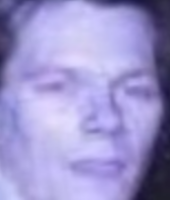

Đã xử lý 1 khuôn mặt.
Trích xuất đặc trưng thành công: Nhãn = 3
Khuôn mặt 24, độ tin cậy: 0.9997174143791199


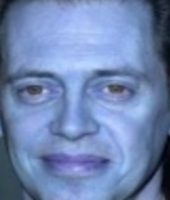

Đã xử lý 1 khuôn mặt.
Trích xuất đặc trưng thành công: Nhãn = 8
Khuôn mặt 25, độ tin cậy: 0.9986530542373657


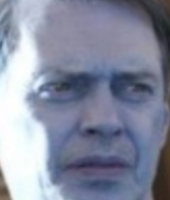

Đã xử lý 1 khuôn mặt.
Trích xuất đặc trưng thành công: Nhãn = 8
Khuôn mặt 26, độ tin cậy: 0.9995194673538208


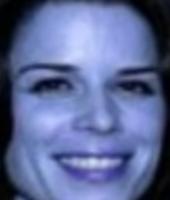

Đã xử lý 1 khuôn mặt.
Trích xuất đặc trưng thành công: Nhãn = 9
Khuôn mặt 27, độ tin cậy: 0.9998284578323364


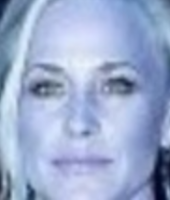

Đã xử lý 1 khuôn mặt.
Trích xuất đặc trưng thành công: Nhãn = 1
Khuôn mặt 28, độ tin cậy: 0.9140910506248474


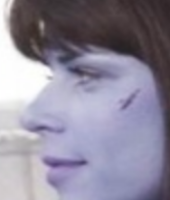

Đã xử lý 1 khuôn mặt.
Trích xuất đặc trưng thành công: Nhãn = 9
Khuôn mặt 29, độ tin cậy: 0.9996122717857361


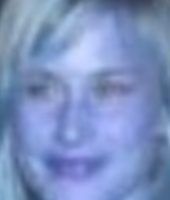

Đã xử lý 1 khuôn mặt.
Trích xuất đặc trưng thành công: Nhãn = 1
Khuôn mặt 30, độ tin cậy: 0.9996790885925293


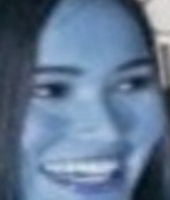

Đã xử lý 1 khuôn mặt.
Trích xuất đặc trưng thành công: Nhãn = 10
Khuôn mặt 31, độ tin cậy: 0.9740474820137024


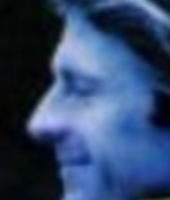

Đã xử lý 1 khuôn mặt.
Trích xuất đặc trưng thành công: Nhãn = 6
Khuôn mặt 32, độ tin cậy: 0.9991552829742432


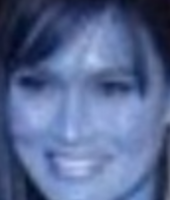

Đã xử lý 1 khuôn mặt.
Trích xuất đặc trưng thành công: Nhãn = 10
Khuôn mặt 33, độ tin cậy: 0.999658465385437


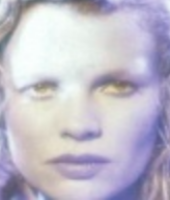

Đã xử lý 1 khuôn mặt.
Trích xuất đặc trưng thành công: Nhãn = 6
Khuôn mặt 34, độ tin cậy: 0.9767947793006897


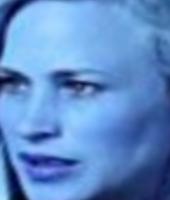

Đã xử lý 1 khuôn mặt.
Trích xuất đặc trưng thành công: Nhãn = 1
Khuôn mặt 35, độ tin cậy: 0.995311439037323


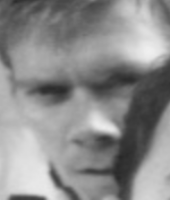

Đã xử lý 1 khuôn mặt.
Trích xuất đặc trưng thành công: Nhãn = 3
Khuôn mặt 36, độ tin cậy: 0.9996844530105591


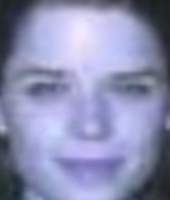

Đã xử lý 1 khuôn mặt.
Trích xuất đặc trưng thành công: Nhãn = 9
Khuôn mặt 37, độ tin cậy: 0.9986701011657715


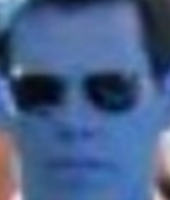

Đã xử lý 1 khuôn mặt.
Trích xuất đặc trưng thành công: Nhãn = 3
Khuôn mặt 38, độ tin cậy: 0.9995768666267395


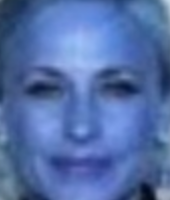

Đã xử lý 1 khuôn mặt.
Trích xuất đặc trưng thành công: Nhãn = 1
Khuôn mặt 39, độ tin cậy: 0.9981569647789001


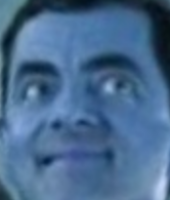

Đã xử lý 1 khuôn mặt.
Trích xuất đặc trưng thành công: Nhãn = 2
Khuôn mặt 40, độ tin cậy: 0.9996875524520874


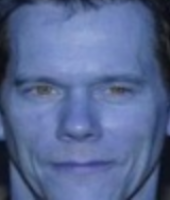

Đã xử lý 1 khuôn mặt.
Trích xuất đặc trưng thành công: Nhãn = 3
Khuôn mặt 41, độ tin cậy: 0.985790491104126


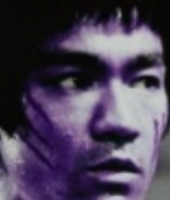

Đã xử lý 1 khuôn mặt.
Trích xuất đặc trưng thành công: Nhãn = 0
Khuôn mặt 42, độ tin cậy: 0.9516233205795288


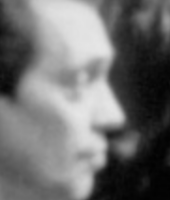

Đã xử lý 1 khuôn mặt.
Trích xuất đặc trưng thành công: Nhãn = 8
Khuôn mặt 43, độ tin cậy: 0.9941843152046204


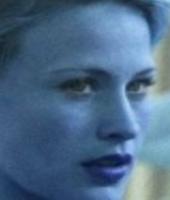

Đã xử lý 1 khuôn mặt.
Trích xuất đặc trưng thành công: Nhãn = 1
Khuôn mặt 44, độ tin cậy: 0.9978600144386292


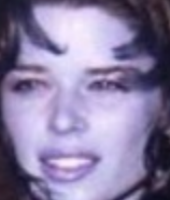

Đã xử lý 1 khuôn mặt.
Trích xuất đặc trưng thành công: Nhãn = 9
Khuôn mặt 45, độ tin cậy: 0.9994712471961975


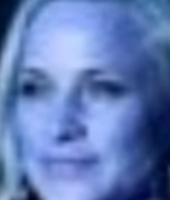

Đã xử lý 1 khuôn mặt.
Trích xuất đặc trưng thành công: Nhãn = 1
Khuôn mặt 46, độ tin cậy: 0.999326229095459


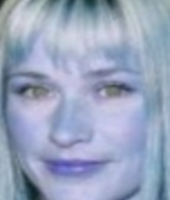

Đã xử lý 1 khuôn mặt.
Trích xuất đặc trưng thành công: Nhãn = 1
Khuôn mặt 47, độ tin cậy: 0.9974579215049744


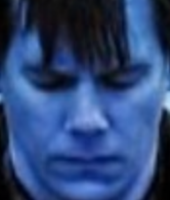

Đã xử lý 1 khuôn mặt.
Trích xuất đặc trưng thành công: Nhãn = 3


KeyboardInterrupt: 

In [15]:
faces_path = '/content/drive/MyDrive/biometric/dataset/casia-webface/train.rec'
data = dict(data=[], label=[])

# Mở file .rec bằng ImageRecordIter
data_iter = mx.io.ImageRecordIter(
    path_imgrec=faces_path,
    data_shape=(3, 224, 224),  # Định dạng kênh, chiều cao, chiều rộng
    batch_size=1,             # Số lượng ảnh trong mỗi batch
    shuffle=True              # Trộn dữ liệu
)

for batch in data_iter:
    try:
        # Lấy ảnh từ batch
        img = batch.data[0][0].asnumpy()
        img = np.transpose(img, (1, 2, 0))  # Chuyển đổi từ (C, H, W) -> (H, W, C)

        # Gọi hàm myDetect với NumPy array
        vector = myDetect(img)

        # Lấy nhãn từ batch
        label = int(batch.label[0].asnumpy()[0])

        # Kiểm tra nếu trích xuất đặc trưng thành công
        if vector is not None:
            data['data'].append(vector)
            data['label'].append(label)
            print(f"Trích xuất đặc trưng thành công: Nhãn = {label}")
    except Exception as e:
        print(f"Lỗi: {e}")
        continue


In [ ]:
fileName = ('/content/drive/MyDrive/biometric/2dface_features.pickle')
pickle.dump(data, open(fileName, mode='wb'))